In [2]:
import os
batch_size = 128
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=" + str(batch_size)
print(os.listdir('../../../../'))
import sys
sys.path.append('..')
sys.path.append('../..')
sys.path.append('../sampler-comparison')
sys.path.append('../../../sampler-evaluation')
sys.path.append('../../../')
sys.path.append('../../../../blackjax')
sys.path.append("../../../../src/inference-gym/spinoffs/inference_gym")
import inference_gym.using_jax as gym
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import sampler_evaluation
#from sampler_comparison.samplers import samplers
import seaborn as sns

import jax
num_cores = jax.local_device_count()
# import inference_gym.using_jax as gym

['probability', '.jupyter', 'blackjax', '.ssh', '.config', '.bash_history', '.udiRoot', '.jupyter.log', 'hierarchical', '.local', 'numpyro', '.condarc', '.ipynb_checkpoints', '.jupyter-perlmutter.log', 'tensorflow_datasets', 'sampler-benchmarks', '.dotnet', '__MACOSX', '.nv', 'jax_nersc_distributed_demo', '.astropy', '.wget-hsts', 'exoprob', '.python_history-73384.tmp', '.jupyter-cori.log', '.lightkurve', '.globus', '.keras', 'periodogram', 'containers', '.conda', 'MicroCanonicalHMC', '.python_history', '.ipython', '.bash_profile', '.selectionfunctionsrc', '.gitconfig', '~', '.lesshst', '.Xauthority', '.viminfo', '.cache', '.bashrc', 'go', '.vscode-server', '.codex']


ModuleNotFoundError: No module named 'tensorflow_probability'

# Drawing from a sampler

Suppose we want to draw samples from the Banana distribution, using the No-U-Turn Sampler. We proceed as follows:

In [5]:
from functools import partial
from sampler_evaluation.models import models
from sampler_comparison.samplers.general import initialize_model
from sampler_evaluation.models.banana import banana
from sampler_evaluation.evaluation.ess import samples_to_low_error, get_standardized_squared_error
from sampler_comparison.samplers.hamiltonianmontecarlo.hmc import adjusted_hmc
from sampler_comparison.samplers.hamiltonianmontecarlo.nuts import nuts
from sampler_evaluation.models.gaussian_mams_paper import IllConditionedGaussian
from sampler_comparison.samplers.microcanonicalmontecarlo.adjusted import adjusted_mclmc

model=IllConditionedGaussian(2,1)


def get_biases(model):
    def sampler(key):
        init_key, sample_key = jax.random.split(key)
        nuts_output, metadata = nuts(num_tuning_steps=500, integrator_type='velocity_verlet',diagonal_preconditioning=True, target_acc_rate=0.8)(
                model=model, 
                num_steps=1000,
                initial_position=jax.random.normal(init_key, shape=(2,)), 
                key=sample_key)
                
        mams_output, metadata = adjusted_mclmc(L_proposal_factor=jnp.inf, random_trajectory_length=False, alba_factor=0.23, target_acc_rate=0.9, num_tuning_steps=500,diagonal_preconditioning=True, integrator_type='velocity_verlet')(
                model=model, 
                num_steps=1000,
                initial_position=jax.random.normal(init_key, shape=(2,)), 
                key=sample_key)
        return nuts_output, mams_output
    return sampler


bias_nuts, bias_mams = jax.pmap(get_biases(model))(jax.random.split(jax.random.key(0), 128))
print(bias_nuts)

ModuleNotFoundError: No module named 'optax'

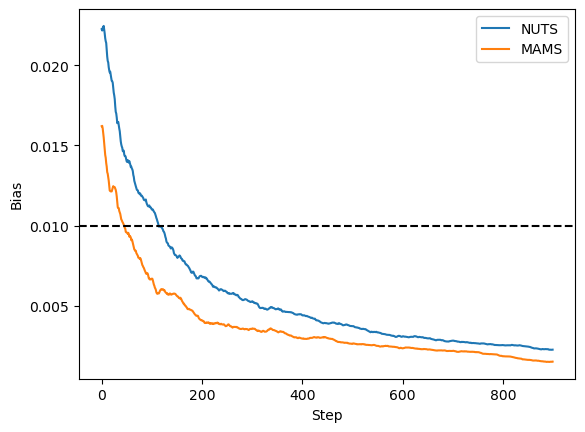

In [3]:
# bias['square']['max'].shape
plt.plot(bias_nuts['square']['avg'].mean(axis=0)[100:], label='NUTS')
plt.plot(bias_mams['square']['avg'].mean(axis=0)[100:], label='MAMS')
# make horizontal line at 0.01
plt.axhline(y=0.01, color='black', linestyle='--')
plt.xlabel('Step')
plt.ylabel('Bias')
plt.legend()
plt.show()